In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import sys

In [2]:
from matplotlib.animation import FuncAnimation

In [3]:
def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [7]:
# Position
x0 = 0
xf = 30
xobs = [[5, 7], [10, 11], [15, 16], [23, 25]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 1000
iter_max = 1000
tMax = 20
vmax = 2
max_time = 5

# Obstacle Setting
# [start, close, open]
obs1 = [0, 2.5, 2.5]
obs2 = [0, 4, 4]
obs3 = [0, 3, 3]
obs4 = [0, 8, 2.5]
obs_vec = [obs1, obs2, obs3, obs4]

In [6]:
x0 = 0
xf = 15
xobs = [[6.25, 10-1.25]]
obs_vec = [[0, 5, 5]]

Text(0, 0.5, 't')

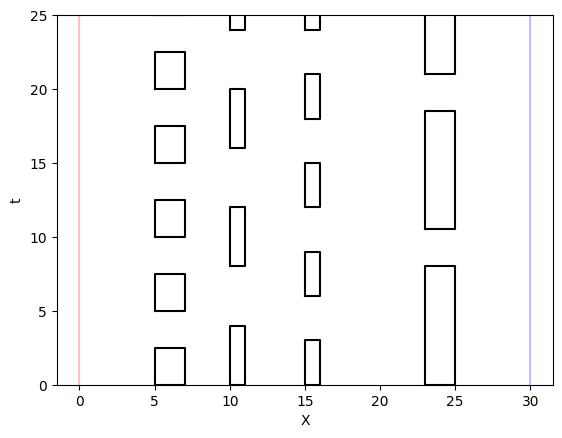

In [9]:
fig = plt.figure()
ax = fig.subplots()
tf = 20
# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, 20+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, 20+5], 'b-', alpha=0.25)

# Plot Limits
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')

In [5]:
def distance(a, b):
    return b - a

def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [6]:
def random_sample():
    n = 1
    trand = rn.uniform(0, 1e3)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [-vmax/2*(trand - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(trand - 1/vmax*(xf+x0)))+x0/vmax]
        point3 = [vmax/2*(trand + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(trand + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    # print('xrand, trand: ', xrand, trand)
    return [xrand, trand]

def check_route(q1, q2, t1):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((t1//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision
    
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    # print('dx, dt: ', dx, dt)
    if dt > 0 and np.abs(dx/dt) <= vmax:
        return True
    else:
        return False
    
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for vi in V:
        if reachable(vi, qrand):
            dist_vec.append(np.sqrt((vi[0]-qrand[0])**2 + (vi[1]-qrand[1])**2))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None
    
def extend(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec
        
def neighbors(prox, q0, V_RRTstar):
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(q0, v):
            output.append(v)
    return output

In [37]:
"""Stardard RRT*"""
k = 0
V_RRTstar = []
V_RRTstar.append([x0, 0])
T_RRTstar = []
T_RRTstar.append(0)
E_RRTstar = []
path_RRTstar = None
while k < K:
    # print('k: ', k)
    while 1:
        # Sample
        qrand = random_sample()
        qclosest = find_neighbor(qrand, V_RRTstar)
        if qclosest is not None:
            qnew = extend(qclosest, qrand, max_time)
            
            # Validate
            check_vec = validate(qnew)
            if np.sum(check_vec) == 0:
                if check_route(qclosest, qnew, qrand[1]):
                    break

    # Add V, E
    k += 1
    V_RRTstar.append(qnew)
    E_RRTstar.append([qclosest, qnew])
    T_RRTstar.append(qnew[1])

    # Rewiring
    if k > 1:
        qmin = qclosest
        cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
        neighbor_vector = neighbors(prox, qnew, V_RRTstar)
        if len(neighbor_vector) > 0:
            for v in neighbor_vector:
                if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                    cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                    qmin = v
            E_RRTstar.append([qnew, qmin])

    # Check continue
    dist_check = []
    if np.abs(distance(xf, V_RRTstar[-1][0])) <= 1:
        dist_check.append(1)
    else:
        dist_check.append(0)
    if np.sum(dist_check) > 0 or k > K:
        dist_to_fin = distance(xf, qnew[0])
        qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
        V_RRTstar.append(qfin)
        E_RRTstar.append([qnew, qfin])
        path_RRTstar = find_path(xf, E_RRTstar)
        total_path_time = 0
        total_path_distance = 0
        for fpv in range(len(path_RRTstar)-1):
            total_path_time += path_RRTstar[fpv+1][1]-path_RRTstar[fpv][1]
            total_path_distance += path_RRTstar[fpv+1][0]-path_RRTstar[fpv][0]
        break

Text(0, 0.5, 't')

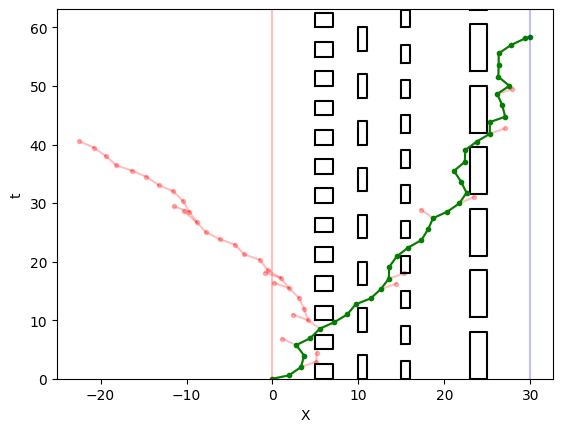

In [38]:
fig = plt.figure()
ax = fig.subplots()
tf = V_RRTstar[-1][1]
# RRTstar
for rrtv in V_RRTstar:
   plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
for rrte in E_RRTstar:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Path
if path_RRTstar is not None:
    for pathi in path_RRTstar:
        plt.plot(pathi[0], pathi[1], '.g')
    for pathi in range(len(path_RRTstar)-1):
        plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# Initial/Final
plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf+1)
plt.ylim(0, max(T_RRTstar)+5)
# plt.xlim(-10, 10)
# plt.ylim(0, 10)
plt.xlabel('X')
plt.ylabel('t')
# plt.grid()

In [39]:
print(len(V_RRTstar)-1)

74


0/74
0/74
1/74
2/74
3/74
4/74
5/74
6/74
7/74
8/74
9/74
10/74
11/74
12/74
13/74
14/74
15/74
16/74
17/74
18/74
19/74
20/74
21/74
22/74
23/74
24/74
25/74
26/74
27/74
28/74
29/74
30/74
31/74
32/74
33/74
34/74
35/74
36/74
37/74
38/74
39/74
40/74
41/74
42/74
43/74
44/74
45/74
46/74
47/74
48/74
49/74
50/74
51/74
52/74
53/74
54/74
55/74
56/74
57/74
58/74
59/74
60/74
61/74
62/74
63/74
64/74
65/74
66/74
67/74
68/74
69/74
70/74
71/74
72/74
73/74
74/74
Plotting Path


/tmp/ipykernel_51639/3346700317.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/74


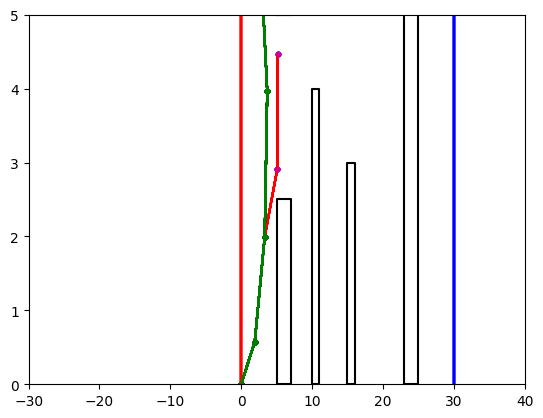

In [45]:
figure, ax = plt.subplots()

# Setting limits for x and y axis
ax.set_xlim(-30, xf+10)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')
 
# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(len(V_RRTstar)-1))
    i = int(i)
    # Initial/Final
    plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
    plt.plot([xf, xf], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)
    ax.set_ylim(0, max(T_RRTstar[:i+1])+5)
    for rrte in V_RRTstar[:i]:
        plt.plot(rrte[0], rrte[1], '.m', alpha=0.25)
    for rrte in E_RRTstar[:i]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)
    if i == len(V_RRTstar)-1:
        print('Plotting Path')
        for ii in range(i):
            for pathi in path_RRTstar:
                plt.plot(pathi[0], pathi[1], '.g')
            for pathi in range(len(path_RRTstar)-1):
                plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')
 
animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(V_RRTstar), 1), 
                          interval = 20)
animation.save('RRTstar_example.mp4', writer="ffmpeg")
fig.show()

In [70]:
"""Standard RRT"""
time_vec = []
RRT_total_time = []
RRT_total_distance = []
success_RRT = 0
k = 0
V_RRT = []
V_RRT.append([x0, 0])
V_RRT_raw = []
T_RRT = []
T_RRT.append(0)
E_RRT = []
sanity = []

# average_iteration = []

path_RRT = None
while k < K:
# while 1:
    # print('k: ', k)
    while 1:
        # Sample
        qrand = random_sample()
        qclosest = find_neighbor(qrand, V_RRT)
        if qclosest is not None:
            qnew = extend(qclosest, qrand, max_time)
            
            # Validate
            check_vec = validate(qnew)
            if np.sum(check_vec) == 0 and check_route(qclosest, qnew, qrand[1]):
                break

    # Add V, E
    k += 1
    #print('qrand: ', qrand)
    #print('qnew: ', qnew)
    V_RRT.append(qnew)
    sanity.append(qrand)
    V_RRT_raw.append(qrand)
    E_RRT.append([qclosest, qnew])
    T_RRT.append(qnew[1])

    # Check continue
    dist_check = []
    if np.abs(distance(xf, qnew[0])) <= 1:
        dist_check.append(1)
    else:
        dist_check.append(0)
    if np.sum(dist_check) > 0:
        dist_to_fin = distance(xf, qnew[0])
        qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
        V_RRT.append(qfin)
        E_RRT.append([qnew, qfin])
        path_RRT = find_path(xf, E_RRT)
        success_RRT += 1
        total_path_time = 0
        total_path_distance = 0
        for fpv in range(len(path_RRT)-1):
            total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
            total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
        RRT_total_time.append(total_path_time)
        RRT_total_distance.append(total_path_distance)
        break

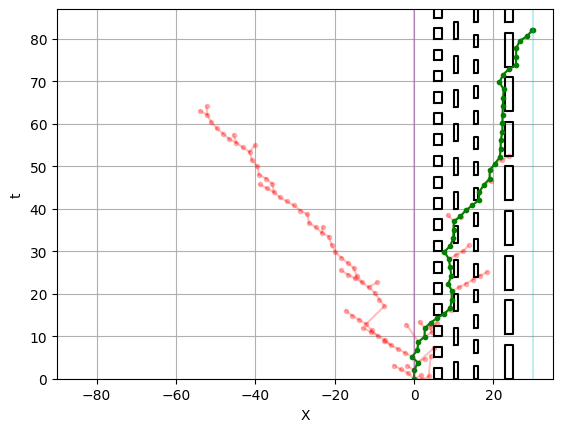

In [71]:
fig = plt.figure()
ax = fig.subplots()
tf = V_RRT[-1][1]
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

Path
if path_RRT is not None:
    for pathi in path_RRT:
        plt.plot(pathi[0], pathi[1], '.g')
    for pathi in range(len(path_RRT)-1):
        plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, max(T_RRT)+5], 'm-', alpha=0.25)
plt.plot([xf, xf], [0, max(T_RRT)+5], 'c-', alpha=0.25)

# Plot Limits
plt.xlim(-90, xf+5)
plt.ylim(0, max(T_RRT)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [72]:
print(len(V_RRT)-1)

138


0/138
0/138
1/138
2/138
3/138
4/138
5/138
6/138
7/138
8/138
9/138
10/138
11/138
12/138
13/138
14/138
15/138
16/138
17/138
18/138
19/138
20/138
21/138
22/138
23/138
24/138
25/138
26/138
27/138
28/138
29/138
30/138
31/138
32/138
33/138
34/138
35/138
36/138
37/138
38/138
39/138
40/138
41/138
42/138
43/138
44/138
45/138
46/138
47/138
48/138
49/138
50/138
51/138
52/138
53/138
54/138
55/138
56/138
57/138
58/138
59/138
60/138
61/138
62/138
63/138
64/138
65/138
66/138
67/138
68/138
69/138
70/138
71/138
72/138
73/138
74/138
75/138
76/138
77/138
78/138
79/138
80/138
81/138
82/138
83/138
84/138
85/138
86/138
87/138
88/138
89/138
90/138
91/138
92/138
93/138
94/138
95/138
96/138
97/138
98/138
99/138
100/138
101/138
102/138
103/138
104/138
105/138
106/138
107/138
108/138
109/138
110/138
111/138
112/138
113/138
114/138
115/138
116/138
117/138
118/138
119/138
120/138
121/138
122/138
123/138
124/138
125/138
126/138
127/138
128/138
129/138
130/138
131/138
132/138
133/138
134/138
135/138
136/138
137/138


/tmp/ipykernel_51639/1941059225.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/138


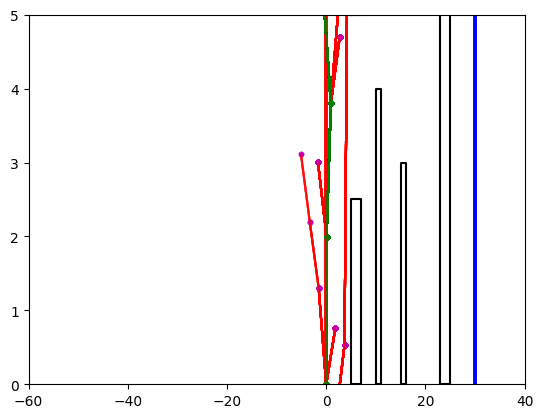

In [73]:
figure, ax = plt.subplots()

# Setting limits for x and y axis
ax.set_xlim(-60, xf+10)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')
 
# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(len(V_RRT)-1))
    i = int(i)
    # Initial/Final
    plt.plot([x0, x0], [0, max(T_RRT)+5], 'r-', alpha=0.25)
    plt.plot([xf, xf], [0, max(T_RRT)+5], 'b-', alpha=0.25)
    ax.set_ylim(0, max(T_RRT[:i+1])+5)
    for rrte in V_RRT[:i]:
        plt.plot(rrte[0], rrte[1], '.m', alpha=0.25)
    for rrte in E_RRT[:i]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)
    if i == len(V_RRT)-1:
        print('Plotting Path')
        for ii in range(i):
            for pathi in path_RRT:
                plt.plot(pathi[0], pathi[1], '.g')
            for pathi in range(len(path_RRT)-1):
                plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')
 
animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(V_RRT), 1), 
                          interval = 20)
animation.save('RRT_example.mp4', writer="ffmpeg")
fig.show()

In [74]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import shapely.ops as so

In [12]:
def distance(a, b):
    return b - a

def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False
    
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

def extend(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))
        else:
            dist_vec.append(1e100)

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None
    
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision
    
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec

In [128]:
# Standard ST-RRT-Connect
RRTC_total_time = []
RRTC_total_distance = []
time_vec_RRTC = []
K = 250
success_RRTC = 0
tf = xf/vmax + 5
t_test = []
V_RRTConnecta = {}
E_RRTConnecta = {}
V_RRTConnectb = {}
E_RRTConnectb = {}
kk = 0
for kek in range(4):
    tmax = tf
    # print('tf: ', tf)
    k = 0
    V_RRTCa = []
    V_RRTCa.append([x0, 0])
    V_RRTCa_raw = []
    V_RRTCb = []
    V_RRTCb.append([xf, tf])
    V_RRTCb_raw = []

    T_RRTCa = []
    T_RRTCb = []
    T_RRTCa.append(0)
    T_RRTCa.append(tf)

    E_RRTCa = []
    E_RRTCb = []

    while k < K:
        t_check = []
        # print('k: ', k)
        while 1:
            # Sample
            sample_start = time.time()
            qrand = random_sample_RRTC(tf, 1, k)
            # print('sample time: ', time.time()-sample_start)
            t_check.append(time.time()-sample_start)

            neighbor_start = time.time()
            if np.mod(k, 2) == 0:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
            else:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
            # print('neighbor check time: ', time.time()-neighbor_start)
            t_check.append(time.time()-neighbor_start)
            
            if qclosest is not None:
                extend_start = time.time()
                qnew = extend(qclosest, qrand, max_time)
                # adfadfaf
                # print('extend time: ', time.time()-extend_start)
                t_check.append(time.time()-extend_start)
                    
                # Validate
                validate_start = time.time()
                check_vec = validate(qnew)
                # print('validation time: ', time.time()-validate_start)
                t_check.append(time.time()-validate_start)
                if np.sum(check_vec) == 0:
                    check_route_start = time.time()
                    kek = check_route_test(qclosest, qnew, tf)
                    # print('route_check: ', time.time()-check_route_start)
                    t_check.append(time.time()-check_route_start)
                    # print('total: ', time.time()-sample_start)
                    if kek:
                        break
            
        # Add V, E
        add_start = time.time()
        if np.mod(k, 2) == 0:
            V_RRTCa.append(qnew)
            E_RRTCa.append([qclosest, qnew])
            T_RRTCa.append(qnew[1])
            V_RRTCa_raw.append(qrand)
        else:
            V_RRTCb.append(qnew)
            E_RRTCb.append([qclosest, qnew])
            T_RRTCb.append(qnew[1])
            V_RRTCb_raw.append(qrand)
        # print('Add time: ', time.time()-add_start)
        t_check.append(time.time()-add_start)

        # Check continue
        path_check_start = time.time()
        path_check = False
        if np.mod(k,2) == 0:
            for vj in V_RRTCb:
                if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                    if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                        connect_edge = [V_RRTCa[-1], vj]
                        path_check = True
                        success_RRTC += 1
                        break
        else:
            for vi in V_RRTCa:
                if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                    if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                        connect_edge = [vi, V_RRTCb[-1]]
                        path_check = True
                        success_RRTC += 1
                        break
        # print('path_check: ', time.time()-path_check_start)
        t_check.append(time.time()-path_check_start)
        # print('total from sample: ', time.time()-sample_start)
        t_test.append(time.time()-sample_start)
        k += 1

        if path_check:
            # print('Path Found')
            path_start = time.time()
            E_RRTC = E_RRTCa + E_RRTCb
            E_RRTC.append(connect_edge)
            patha_start = time.time()
            patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
            # print('Path a: ', time.time()-patha_start)
            pathb_start = time.time()
            pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
            # print('Path b: ', time.time()-pathb_start)
            final_path = list(reversed(patha)) + pathb
            # print('path compute: ', time.time()-path_start)
            total_path_time = 0
            total_path_distance = 0
            for fpv in range(len(final_path)-1):
                total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
            RRTC_total_time.append(total_path_time)
            RRTC_total_distance.append(total_path_distance)
            break
    V_RRTConnecta[str(kk)] = V_RRTCa
    E_RRTConnecta[str(kk)] = E_RRTCa
    V_RRTConnectb[str(kk)] = V_RRTCb
    E_RRTConnectb[str(kk)] = E_RRTCb

    # print('Path_check: ', path_check)
    if path_check:
        break
    tf += 10
    kk += 1

Text(0, 0.5, 't')

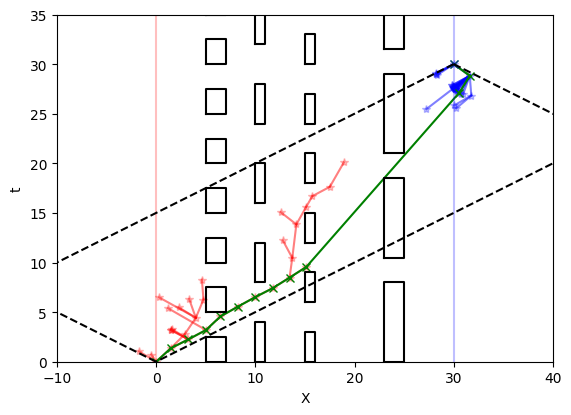

In [129]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrtv in V_RRTCb:
   plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
# for rrtvr in V_RRTCa_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.', alpha=0.25)
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'c.', alpha=0.25)
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
for rrte in E_RRTCb:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(x0-10, xf+10)
plt.ylim(0, tf+5)
# plt.xlim(25, 35)
# plt.ylim(30, 45)
plt.xlabel('X')
plt.ylabel('t')

In [137]:
print(xf/vmax + 5)
print(len(V_RRTConnecta.keys()))
print(V_RRTConnecta.keys())
print(len(V_RRTConnecta['0'])+len(V_RRTConnecta['1']))

20.0
2
dict_keys(['0', '1'])
157


In [140]:
print(len(V_RRTConnecta['0']))

126


In [ ]:
figure, ax = plt.subplots()

# Setting limits for x and y axis
ax.set_xlim(x0-10, xf+10)
 
# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(len(V_RRTConnecta['0'])+len(V_RRTConnecta['1'])+len(V_RRTConnectb['0'])+len(V_RRTConnectb['1'])-1))
    i = int(i)

    # ST-Bound
    if i <= len(V_RRTConnecta['0'])+len(V_RRTConnectb['0']):
        tf = xf/vmax + 5
        ax.set_ylim(0, tf+5)
        # Initial/Final
        plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
        plt.plot(xf, tf, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

        # Obstacle
        tspace = np.linspace(0, tf+5, 100)
        for ii in range(len(xobs)):
            obs_number = int((tf+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        if np.mod(i, 2) == 0:
            for rrte in V_RRTConnecta['0'][:i//2]:
                plt.plot(rrte[0], rrte[1], '.m', alpha=0.25)
            for rrte in E_RRTConnecta['0'][:i//2]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'm-', alpha=0.25)
        else:
            for rrte in V_RRTConnectb['0'][:i//2]:
                plt.plot(rrte[0], rrte[1], '.c', alpha=0.25)
            for rrte in E_RRTConnectb['0'][:i//2]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'c-', alpha=0.25)
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        # if i == len(V_RRTConnecta['0'])+len(V_RRTConnectb['0'])+1:
        #     plt.clf()
        # else:
        #     pass
    else:
        # plt.clf()
        tf = xf/vmax + 15
        ax.set_ylim(0, tf+5)
        # Initial/Final
        plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
        plt.plot(xf, tf, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

        # Obstacle
        tspace = np.linspace(0, tf+5, 100)
        for ii in range(len(xobs)):
            obs_number = int((tf+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        if np.mod(i, 2) == 0:
            for rrte in V_RRTConnecta['1'][:i//2]:
                plt.plot(rrte[0], rrte[1], '.m', alpha=0.25)
            for rrte in E_RRTConnecta['1'][:i//2]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)
        else:
            for rrte in V_RRTConnectb['1'][:i//2]:
                plt.plot(rrte[0], rrte[1], '.b', alpha=0.25)
            for rrte in E_RRTConnectb['1'][:i//2]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.25)
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
    if i == len(V_RRTConnecta['0'])+len(V_RRTConnecta['1'])+len(V_RRTConnectb['0'])+len(V_RRTConnectb['1'])-1:
        tf = xf/vmax + 15
        ax.set_ylim(0, tf+5)
        print('Plotting Path')
        for pathi in final_path:
            plt.plot(pathi[0], pathi[1], '.g')
        for pathi in range(len(final_path)-1):
            plt.plot([final_path[pathi][0], final_path[pathi+1][0]], [final_path[pathi][1], final_path[pathi+1][1]], '-g')

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, len(V_RRTConnecta['0'])+len(V_RRTConnecta['1'])+len(V_RRTConnectb['0'])+len(V_RRTConnectb['1']), 1), 
                        #   frames = np.arange(0, 30, 1), 
                          interval = 25)
animation.save('RRTC_test.mp4', writer="ffmpeg")
fig.show()

TEST

In [18]:
# Standard ST-RRT-Connect with parallel goal tree
RRTC_total_time = []
RRTC_total_distance = []
time_vec_RRTC = []
K = 1000*5
success_RRTC = 0
tf = xf/vmax + 5
t_test = []
V_RRTConnecta = {}
E_RRTConnecta = {}
V_RRTConnectb = {}
E_RRTConnectb = {}
kk = 0
n = 10
tf0 = xf/vmax + 5
tfn = 60
tfSelection = []
for ii in range(n):
    tfSelection.append(rn.uniform(tf0, tfn))
k = 0
V_RRTCa = []
V_RRTCa.append([x0, 0])
V_RRTCb = {}
T_RRTCb = {}
E_RRTCb = {}
for ii in range(n):
    V_RRTCb[str(ii)] = []
    V_RRTCb[str(ii)].append([xf, tfSelection[ii]])
    T_RRTCb[str(ii)] = []
    T_RRTCb[str(ii)].append(tfSelection[ii])
    E_RRTCb[str(ii)] = []
T_RRTCa = []
T_RRTCa.append(0)

E_RRTCa = []

print(tfSelection)
# print(V_RRTCb)

while k < K:
    t_check = []
    print('k: ', k)
    for ii in range(n):
        tf = tfSelection[ii]
        while 1:
            # Sample
            qrand = random_sample_RRTC(tf, 1, k)

            if np.mod(k, n) == 0:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
            else:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCb[str(ii)], k)
            
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                    
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route_test(qclosest, qnew, tf):
                    break
            
        # Add V, E
        if np.mod(k, n) == 0:
            V_RRTCa.append(qnew)
            E_RRTCa.append([qclosest, qnew])
            T_RRTCa.append(qnew[1])
        else:
            V_RRTCb[str(ii)].append(qnew)
            E_RRTCb[str(ii)].append([qclosest, qnew])
            T_RRTCb[str(ii)].append(qnew[1])

        # Check continue
        path_check_start = time.time()
        path_check = False
        if np.mod(k, n) == 0:
            for vj in V_RRTCb[str(ii)]:
                if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                    if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                        connect_edge = [V_RRTCa[-1], vj]
                        path_check = True
                        success_RRTC += 1
                        break
        else:
            for vi in V_RRTCa:
                if reachable_RRTC(vi, V_RRTCb[str(ii)][-1], forward=False):
                    if check_route_test(vi, V_RRTCb[str(ii)][-1], tf) and reachable_RRTC(vi, V_RRTCb[str(ii)][-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                        connect_edge = [vi, V_RRTCb[str(ii)][-1]]
                        path_check = True
                        success_RRTC += 1
                        break
        if path_check:
            break
    k += 1

    if path_check:
        print('Path Found')
        path_start = time.time()
        E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
        E_RRTC.append(connect_edge)
        patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
        pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb[str(ii)], E_RRTCb[str(ii)], 1)
        final_path = list(reversed(patha)) + pathb
        total_path_time = 0
        total_path_distance = 0
        for fpv in range(len(final_path)-1):
            total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
            total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
        RRTC_total_time.append(total_path_time)
        RRTC_total_distance.append(total_path_distance)
        tf_for_path = tf
        print(tf_for_path)
        break

[92.11058185606701, 85.83025061226677, 83.05749676448839, 67.32878192830485, 59.82443347274249]
k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
Path Found
67.32878192830485


Lets try out this:
1. grow tree from x0
2. grow tree from tf1, tf2, tf3, tf4, ... tfn
3. try connection test bewteen x0 and xf tree
4. whichever makes connection terminates the iteration and return result

How is this better than just selecting big big tf?
-> might be faster to converge to closer tf than converging to big big tf

How do we check this?
-> Monte-Carlo to compare RRT-Connect with big big tf, RRT-Connect with small tf and update overtime, RRT-Connect with multipel tf

Also, we need to optimize RRT time shadow

Text(0, 0.5, 't')

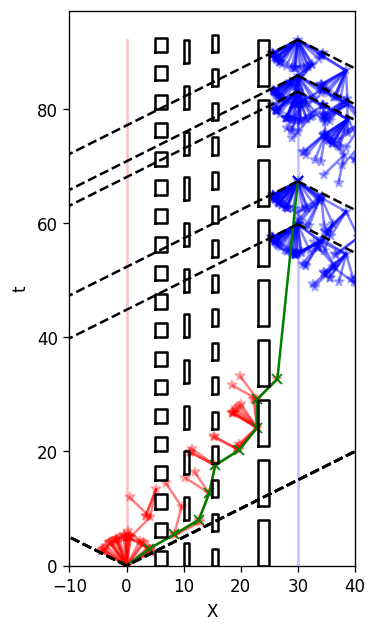

In [20]:
fig = plt.figure(figsize=(6, 6), dpi=(1920/16))
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
for ii in range(n):
    for rrtv in V_RRTCb[str(ii)]:
        plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
    for rrte in E_RRTCb[str(ii)]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
maxTf = max(tfSelection)
tspace = np.linspace(0, maxTf, 100)
for i in range(len(xobs)):
    obs_number = int((maxTf//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, maxTf], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, maxTf], 'b-', alpha=0.25)
for ii in range(n):
    plt.plot(xf, tf, 'xb', alpha=0.5)

# ST-Bound
for ii in range(n):
    tfi = tfSelection[ii]
    point1 = [x0, 0]
    point2 = [xf, tfi]
    point3 = [-vmax/2*(tfi - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tfi - 1/vmax*(xf+x0)))+x0/vmax]
    point4 = [vmax/2*(tfi + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tfi + 1/vmax*(xf+x0))) - x0/vmax]
    plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
    plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
    plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
    plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
plt.xlim(x0-10, xf+10)
plt.ylim(0, maxTf+5)
plt.xlabel('X')
plt.ylabel('t')


360
0/360
0/360
1/360
2/360
3/360
4/360
5/360
6/360
7/360
8/360
9/360
10/360
11/360
12/360
13/360
14/360
15/360
16/360
17/360
18/360
19/360
20/360
21/360
22/360
23/360
24/360
25/360
26/360
27/360
28/360
29/360
30/360
31/360
32/360
33/360
34/360
35/360
36/360
37/360
38/360
39/360
40/360
41/360
42/360
43/360
44/360
45/360
46/360
47/360
48/360
49/360
50/360
51/360
52/360
53/360
54/360
55/360
56/360
57/360
58/360
59/360
60/360
61/360
62/360
63/360
64/360
65/360
66/360
67/360
68/360
69/360
70/360
71/360
72/360
73/360
74/360
75/360
76/360
77/360
78/360
79/360
80/360
81/360
82/360
83/360
84/360
85/360
86/360
87/360
88/360
89/360
90/360
91/360
92/360
93/360
94/360
95/360
96/360
97/360
98/360
99/360
100/360
101/360
102/360
103/360
104/360
105/360
106/360
107/360
108/360
109/360
110/360
111/360
112/360
113/360
114/360
115/360
116/360
117/360
118/360
119/360
120/360
121/360
122/360
123/360
124/360
125/360
126/360
127/360
128/360
129/360
130/360
131/360
132/360
133/360
134/360
135/360
136/360
137/

/tmp/ipykernel_318147/2368889436.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/360


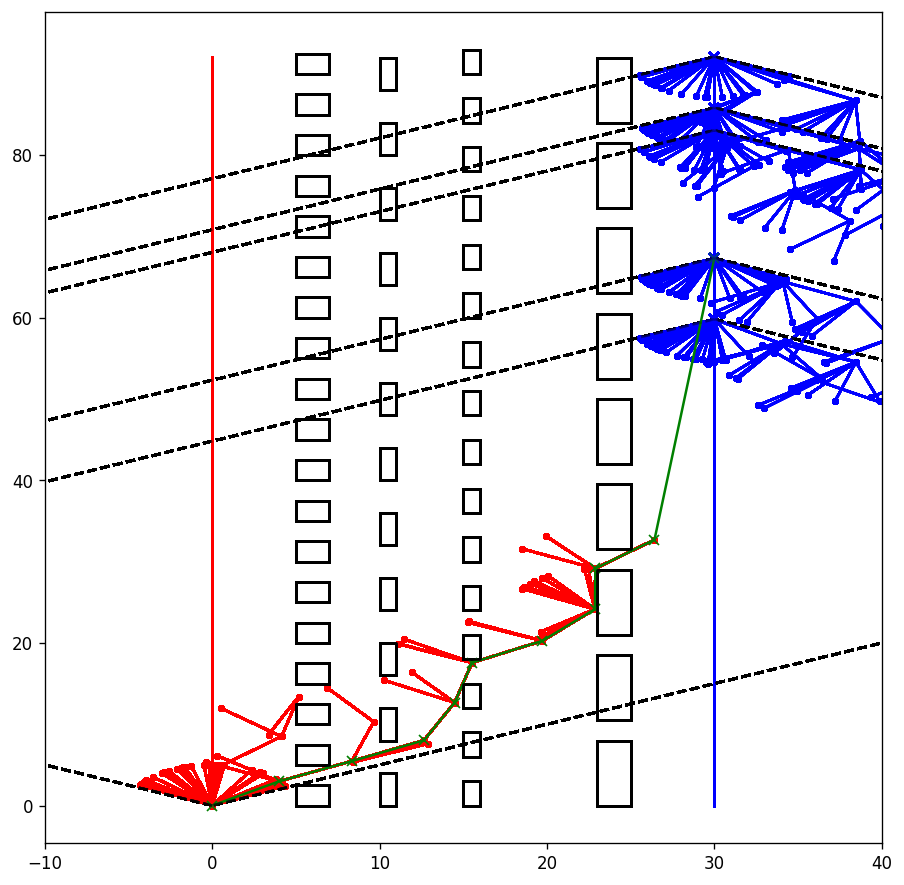

In [23]:
figure, ax = plt.subplots(figsize=(9, 9), dpi=(1920/16))
plt.clf()

# Total points
total_points = 0
total_points += len(V_RRTCa)
for ii in range(n):
    total_points += len(V_RRTCb[str(ii)])
print(total_points)

# Setting limits for x and y axis
 
# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(total_points))
    i = int(i)
    k = np.mod(i,n)
    # RRTConnect
    for rrtv in V_RRTCa[:i]:
        plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
    for rrte in E_RRTCa[:i]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)
    for rrtv in V_RRTCb[str(k)][:i]:
        plt.plot(rrtv[0], rrtv[1], 'b.', alpha=0.25)
    for rrte in E_RRTCb[str(k)][:i]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.25)

    # Obstacle
    maxTf = max(tfSelection)
    tspace = np.linspace(0, maxTf, 100)
    for ii in range(len(xobs)):
        obs_number = int((maxTf//np.sum(obs_vec[ii]))+1)
        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
            plt.plot(*this_obstacle.exterior.xy, 'k')

    # Initial/Final
    plt.plot([x0, x0], [0, maxTf], 'r-', alpha=0.25)
    plt.plot([xf, xf], [0, maxTf], 'b-', alpha=0.25)
    for ii in range(n):
        plt.plot(xf, tfSelection[ii], 'xb', alpha=0.5)

    # ST-Bound
    for ii in range(n):
        tfi = tfSelection[ii]
        point1 = [x0, 0]
        point2 = [xf, tfi]
        point3 = [-vmax/2*(tfi - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tfi - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tfi + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tfi + 1/vmax*(xf+x0))) - x0/vmax]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k', alpha=0.25)
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k', alpha=0.25)
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k', alpha=0.25)
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k', alpha=0.25)
    ax.set_xlim(x0-10, xf+10)
    plt.xlim(x0-10, xf+10)
    ax.set_ylim(0, maxTf)

    if i == total_points-1:
        print('Plotting Path')
        for pathi in final_path:
            plt.plot(pathi[0], pathi[1], 'gx')
        for ii in range(len(final_path)-1):
            plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')
    plt.xlim(x0-10, xf+10)

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, total_points, 1), 
                        #   frames = np.arange(0, 20, 1), 
                          interval = 25)
animation.save('RRTC_test_K.mp4', writer="ffmpeg")
fig.show()